##### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2022 Semester 1

## Assignment 2: Sentiment Classification of Tweets

This is a sample code to assist you with vectorising the 'Train' dataset for your assignment 2.

First we read the CSV datafiles (Train and Test).

In [1]:
import pandas as pd
import numpy as np
train_data = pd.read_csv("Train.csv", sep=',')
test_data = pd.read_csv("Test.csv", sep=',')

Then we separate the tweet text and the label (sentiment). 

In [2]:
#separating instance and label for Train
X_train_raw = [x[0] for x in train_data[['text']].values]
Y_train_final = [x[0] for x in train_data[['sentiment']].values]
# obtain tweet id for test data
tweet_id = test_data['id']

#check the result
print("Train length:",len(X_train_raw))

#separating instance and label for Test
X_test_raw = [x[0] for x in test_data[['text']].values]

#check the result
print("Test length:",len(X_test_raw))


Train length: 21802
Test length: 6099


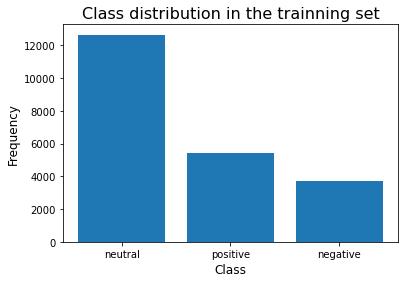

In [3]:
# class distriution in the trainning set shows that class distributed unevenly. 
import matplotlib.pyplot as plt
import collections
count = dict(collections.Counter(Y_train_final))
freq = list(count.values())
sentiment = list(count.keys())
plt.bar(sentiment, freq)
plt.title("Class distribution in the trainning set", fontsize = 16)
plt.xlabel("Class", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.savefig("Class distribution in the trainning set")
plt.show()

In [4]:
#Let's see one example tweet
print(X_train_raw[0])

 doctors hit campaign trail as race to medical council elections heats up https://t.co/iifdwb9v0w #homeopathy


In [5]:
import nltk
import sys  
from word2number import w2n

# use the following line to install packages if haven't
# nltk.download()
# !{sys.executable} -m pip install contractions
# !pip install word2number

In [6]:
from word2number import w2n
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize

# This cell contains some functions which will be used in preprocessing. 

# This function takes a str and convert any number in word to numeric numbers
def wordtonum(text):
    lst = text.split()
    res = []
    for word in lst:
        try:
            res += [str(w2n.word_to_num(word))]
        except ValueError:
            res += [word] 
    return ' '.join(res)

# This lemmatises noun, verb and adjectives at the same time accroding to its 'nltk.tag'. 
# Referenced at: 
# Jonathan. (2016, September 7). python 3.x - apply multiple pos argument in lemmatization. Stack Overflow. 
# Retrieved May 12, 2022, from https://stackoverflow.com/questions/39361976/apply-multiple-pos-argument-in-lemmatization
def lemmatize_all(sentence):
    wnl = WordNetLemmatizer()
    for word, tag in pos_tag(word_tokenize(sentence)):
        if tag.startswith("NN"):
            yield wnl.lemmatize(word, pos='n')
        elif tag.startswith('VB'):
            yield wnl.lemmatize(word, pos='v')
        elif tag.startswith('JJ'):
            yield wnl.lemmatize(word, pos='a')
        else:
            yield word

In [7]:
import re
import string
import nltk
import contractions
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

# generate stopwords in english in a list and remove the negatives in the list since we wish to keep negatives in text
stop = stopwords.words('english')
stop.remove('nor')
stop.remove('no')
stop.remove('not')


# preprocess dataset to remove strings that are not useful
def preprocess(dataset):
    data = dataset.copy()
    # run through all the data
    for i in range(len(data)):   

        # convert all string to lowercase
        data[i] = data[i].lower()
        
        # expand contractions (e.g. "don't" to "do not")
        data[i] = contractions.fix(data[i])\
        
        # remove all URLs since they are not informative to the predicted label
        data[i] = re.sub(r'https?:\/\/\S+', '', data[i])
        
        # remove all the '@username' since they are not informative to the predicted label
        data[i] = re.sub(r'@\S+', '', data[i])
        
        # convert all the number in words to numeric number. (e.g. "three" -> "3")
        data[i] = wordtonum(data[i])
        # remove all the digits since they are not informative to the label, 
        # for dates('21st', '22nd', '23rd'and '24th'): remove both digit and the following "st" 
        # for combination of digit and word, like "12stay": remove the '12' and keep the word 'stay'
        data[i] = re.sub(r'\d+([th]|[rd]|[nd]|[st]){0,2}\b', '', data[i])
        data[i] = re.sub(r'\d', '', data[i])

        # remove punctuations
        data[i] = data[i].translate(str.maketrans('', '', string.punctuation))
        
        # remove consecutive non-ASCII characters
        data[i] = re.sub(r'[^\x00-\x7f]', '', data[i])
        
        # remove elongated words that has 3 or more consequtive letter to one, (eg. "whyyyy" -> "why")
        # (.) -> any letter, \1{3,} a letter that occurs 3 or more times, '\1' replaced by one of this letter 
        data[i] = re.sub(r'(.)\1{3,}', r'\1', data[i])
        
        # split the string to remove stopwords
        data[i] = ' '.join([word for word in data[i].split() if word not in stop])
        
        # lemmatize the string to reduce useless features after splitting
        data[i] = ' '.join(lemmatize_all(data[i]))
        
        # remove single letter from the data (considered to be useless) (e.g. "u", "f"...)
        data[i] = ' '.join([word for word in data[i].split() if len(word) > 1])

    return data

# get all words from the input data, use for checking the number of features
def get_words(data):
    word_list = []
    for i in range(len(data)):
        a = data[i].split()
        for word in a:
            word_list.append(word)
    return list(set(word_list))


# preprocess training and test data set to be clean
X_train_clean = preprocess(X_train_raw)
X_test_clean = preprocess(X_test_raw)
# check percentage of features (words) remaining after preprocessing
train_raw_features = get_words(X_train_raw)
train_clean_features = get_words(X_train_clean)


# print out the correponding data after preprocessing
print("Original count of feature: ", len(train_raw_features))
print("Reduced count of feature : ", len(train_clean_features))
print("Percentage of features remaining after preprocessing is: {:.2f} %".format(len(train_clean_features)/len(train_raw_features)*100))

Original count of feature:  69285
Reduced count of feature :  24892
Percentage of features remaining after preprocessing is: 35.93 %


### Validation Set

In [8]:
# Split the training data to a subset of training data and a validation set, 
# which will be used to estimate the model performance
# The original training set was randomly splitted into 2 parts, while keeping the size of testing set 
# consistent with the original testing set (6099 instances). 
# Since there are 21802 instances in the original training set, the test_size ratio is 6099/21802  0.28.

from sklearn.model_selection import train_test_split 

X_train, X_test, Y_train, Y_test = train_test_split(X_train_clean, Y_train_final, test_size=0.28, shuffle=False, random_state=42)

print("There are",len(X_train), "instances in sub_training set.")
print("There are", len(X_test), "instances in validation set.")

There are 15697 instances in sub_training set.
There are 6105 instances in validation set.


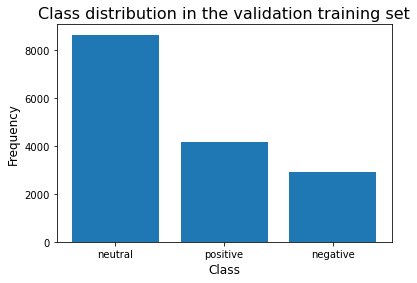

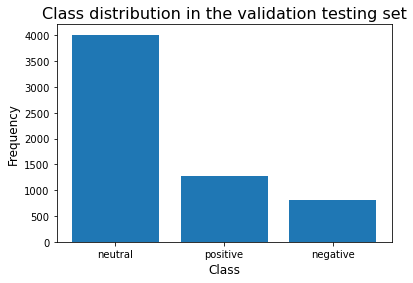

In [13]:
# This cell generates a figure which shows that class distriution unevenly in the validation set. 
import matplotlib.pyplot as plt
import collections
count = dict(collections.Counter(Y_train).most_common())
freq = list(count.values())
sentiment = list(count.keys())
plt.bar(sentiment, freq)
plt.title("Class distribution in the validation training set", fontsize = 16)
plt.xlabel("Class", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.savefig('class distribution in the validation training set')
plt.show()


count = dict(collections.Counter(Y_test).most_common())
freq = list(count.values())
sentiment = list(count.keys())
plt.bar(sentiment, freq)
plt.title("Class distribution in the validation testing set", fontsize = 16)
plt.xlabel("Class", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.savefig('class distribution in the validation testing set')
plt.show()


### 1. Bag of Words (BoW)
In this approach, we use the **CountVectorizer** library to separate all the words in the Train corpus (dataset). These words are then used as the 'vectors' or 'features' to represent each instance (Tweet) in `Train` and `Test` datasets. 

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# This function uses Bag of Words to vectorise text into features for each instance in both trainning and test dataset
# returns matrix of X_train_BoW, X_test_BoW, 'features' after vectorisation and convert the created vocabulary to a csv file.
def BoW(X_train_clean, X_test_clean, ngram):

    BoW_vectorizer = CountVectorizer(analyzer='word', tokenizer=word_tokenize, ngram_range=ngram, min_df=1)
    #Build the feature set (vocabulary) and vectorise the Tarin dataset using BoW
    X_train_BoW = BoW_vectorizer.fit_transform(X_train_clean)

    #Use the feature set (vocabulary) from Train to vectorise the Test dataset 
    X_test_BoW = BoW_vectorizer.transform(X_test_clean)

    features = BoW_vectorizer.get_feature_names()
    
    # We can save the created vocabulary for the given dataset in a separate file.
    output_dict = BoW_vectorizer.vocabulary_
    output_pd = pd.DataFrame(list(output_dict.items()),columns = ['word','index'])
    output_pd.T.to_csv('BoW-vocab.csv',index=False)
    
    return X_train_BoW, X_test_BoW, features, output_pd

Now each row is a list of tuples with the vector_id (word_id in the vocabulary) and the number of times it repeated in that given instance (tweet).

### 2. TFIDF
In this approach, we use the **TfidfVectorizer** library to separate all the words in this corpus (dataset). Same as the BoW approach, these words are then used as the 'vectors' or 'features' to represent each instance (Tweet).

However, in this method for each instance the value associated with each 'vector' (word) is not the number of times the word repeated in that tweet, but the TFIDF value of then 'voctor' (word).

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

# this function is TFIDF vectorization
def TFIDF(X_train_clean, X_test_clean, ngram):
    tfidf_vectorizer = TfidfVectorizer(analyzer='word', tokenizer=word_tokenize, ngram_range=ngram, min_df=1)

    #Build the feature set (vocabulary) and vectorise the Tarin dataset using TFIDF
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_clean)

    #Use the feature set (vocabulary) from Train to vectorise the Test dataset 
    X_test_tfidf = tfidf_vectorizer.transform(X_test_clean)

    return X_train_tfidf, X_test_tfidf

In [16]:
# This cell vectorises text depending on 'method'. 'method' can be "TFIDF" or "BoW".
def vectorizer(X_train_clean, X_test_clean, method, ngram):
    # BoW: CountVectorizer
    if method == "BoW":
        X_train_vec, X_test_vec, features, output_pd = BoW(X_train_clean, X_test_clean, ngram=ngram)
        
    # TFIDF: TfidfVectorizer
    else:
        X_train_vec, X_test_vec = TFIDF(X_train_clean, X_test_clean, ngram=ngram)
    
    return X_train_vec, X_test_vec

# 3. Conduct Machine Learning
We need to first select features from the preprocessed data

In [17]:
# This cell implements feature selections.
import math
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif, VarianceThreshold


# This function selects the most important features through 4 different ways depending on the parameter "method".
# For best-k selection: 1. 'method' takes three different measurements, including "k-best-chi", "k-best-F" and "k-best-MI"
#                       2. function takes an extra parameter "kratio", which indicates how much k should be selected
# For varianceThreshold selection: 1. method = "var-threshold"; takes an extra parameter "var_threshold"
#                                  2. any features that has a variance below 'var_threshold' will be removed
def feature_selection(X_train, Y_train, X_test, method, kratio=0, var_threshold=0):
    
    # let the number of top features selected be a half of the original number of features
    k = math.ceil(X_train.shape[1]*kratio)
    
    
    # k-best with chisquare selection:
    if method == "k-best-chi":
        selector = SelectKBest(chi2, k=k)
        
    # k-best with F test selection:
    elif method == "k-best-F":
        selector = SelectKBest(f_classif, k=k)
        
    # k-best with Mutual information selection:    
    elif method == "k-best-MI":
        selector = SelectKBest(mutual_info_classif, k=k)
    
    # Variance Threshold selection:
    elif method == "var-threshold":
        selector = VarianceThreshold(threshold=var_threshold)
    
    # select features for training set
    X_train_selected = selector.fit_transform(X_train, Y_train)
    # fit the same features from training to testing
    X_test_selected = selector.transform(X_test)
    
    return X_train_selected, X_test_selected


# Baseline Model (0-R)

In [31]:
from sklearn.dummy import DummyClassifier
from collections import Counter
# 0-R baseline model
# this is a model prediction we need to beat

zero_r = DummyClassifier(strategy= 'most_frequent')

# predict for validation set
zero_r.fit(X_train, Y_train)
zr_pred = zero_r.predict(X_test) 
print("Base model (0-R) validation accuracy is: ", zero_r.score(X_test, Y_test))


Base model (0-R) validation accuracy is:  0.3280999679589875


In [16]:
# predict for testing set
import time
t0 = time.time()
pred = zero_r.fit(X_train_clean, Y_train_final).predict(X_test_clean)
df = pd.DataFrame(data={"id": tweet_id, "sentiment": pred})
df.to_csv('baseline.csv', index=False)
t1 = time.time() - t0

In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from matplotlib import cm

# This is to ignore the warning in calculating the precision metric since the zero-R simply predict everything as 'Nuetral'
import warnings
warnings.filterwarnings("ignore")

labels=['negative','neutral','positive']


# save all the information for baseline model, which might be used later
baseline_metrics={}
baseline_metrics['accuracy'] = accuracy_score(Y_test, zr_pred)
baseline_metrics['weighted_precision'] = precision_score(Y_test, zr_pred, average="weighted")
baseline_metrics['weighted_recall'] = recall_score(Y_test, zr_pred, average="weighted")
baseline_metrics['weighted_f1'] = f1_score(Y_test, zr_pred, average="weighted")
baseline_metrics['confusion_M'] = confusion_matrix(Y_test, zr_pred)
baseline_metrics['time'] = t1
baseline_metrics

{'accuracy': 0.6571662571662572,
 'weighted_precision': 0.43186748955790727,
 'weighted_recall': 0.6571662571662572,
 'weighted_f1': 0.5212120240686021,
 'confusion_M': array([[   0,  814,    0],
        [   0, 4012,    0],
        [   0, 1279,    0]]),
 'time': 0.053334951400756836}

# Multinomial Naive Bayes

In [18]:
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB 
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score


def MNB(validation=False):
    
    # fit the multinomialNB model
    mnb = MultinomialNB()
    
    # if we are just validate the accuracy using a subset of trainning set
    if validation == True:
        
        pred = mnb.fit(X_train_sub, Y_train).predict(X_test_sub)
        accuracy = accuracy_score(Y_test, pred)
        
        # "weighed-averaging" is used to determine the f1-score since there exists unbalanced class distribution
        avg_f1 = f1_score(Y_test, pred,average = 'weighted')
        
        return accuracy, avg_f1, pred

    # training using the whole trainning set and predict for the testing set with unknown label
    else:
        pred = mnb.fit(X_train_final, Y_train_final).predict(X_test_final)
        # save test prediction as a csv file
        df = pd.DataFrame(data={"id": tweet_id, "sentiment": pred})
        df.to_csv('MNB.csv', index=False)

        return pred
    
    

In [19]:
# testing to find the best parameters using "k-best-chi"
method = ["BoW", "TFIDF"]
ratio = [0.4,0.5,0.6,0.7]

# go through both method with different ratio to test the best method and parameter

for mtype in method:
    max_f1score = 0
    f1_k_ratio = 0
    max_accuracy = 0
    acc_k_ratio = 0
    
    X_train_vec, X_test_vec = vectorizer(X_train, X_test, method=mtype, ngram=(1,1))
    for k in ratio:
        X_train_sub, X_test_sub = feature_selection(X_train_vec, Y_train, X_test_vec, method="k-best-chi", kratio=k)
        
        accuracy, avg_f1, pred = MNB(validation=True)
        if avg_f1 > max_f1score:
            max_f1score = avg_f1
            f1_k_ratio = k
        if accuracy > max_accuracy:
            max_accuracy = accuracy
            acc_k_ratio = k

    print(mtype)
    print("The model with the highest accuracy: ", max_accuracy, "with k_ratio of ", acc_k_ratio)
    print("The model with the highest weighed-averaging f1_score is :", max_f1score, "with k_ratio of ", f1_k_ratio)
    print("\n")
    

BoW
The model with the highest accuracy:  0.6422604422604422 with k_ratio of  0.4
The model with the highest weighed-averaging f1_score is : 0.6412661947870919 with k_ratio of  0.4


TFIDF
The model with the highest accuracy:  0.6753480753480754 with k_ratio of  0.5
The model with the highest weighed-averaging f1_score is : 0.5949916797428245 with k_ratio of  0.5




In [20]:
# testing to find the best parameters using "k-best-F"

# go through both method with different ratio to test the best method and parameter
for mtype in method:
    max_f1score = 0
    f1_k_ratio = 0
    max_accuracy = 0
    acc_k_ratio = 0
    
    X_train_vec, X_test_vec = vectorizer(X_train, X_test, method=mtype, ngram=(1,1))
    for k in ratio:
        X_train_sub, X_test_sub = feature_selection(X_train_vec, Y_train, X_test_vec, method="k-best-F", kratio=k)
        
        accuracy, avg_f1, pred = MNB(validation=True)
        if avg_f1 > max_f1score:
            max_f1score = avg_f1
            f1_k_ratio = k
        if accuracy > max_accuracy:
            max_accuracy = accuracy
            acc_k_ratio = k

    print(mtype)
    print("The model with the highest accuracy: ", max_accuracy, "with k_ratio of ", acc_k_ratio)
    print("The model with the highest weighed-averaging f1_score is :", max_f1score, "with k_ratio of ", f1_k_ratio)
    print("\n")

BoW
The model with the highest accuracy:  0.6434070434070434 with k_ratio of  0.4
The model with the highest weighed-averaging f1_score is : 0.6423965054708233 with k_ratio of  0.4


TFIDF
The model with the highest accuracy:  0.6755118755118755 with k_ratio of  0.5
The model with the highest weighed-averaging f1_score is : 0.594393041907828 with k_ratio of  0.5




From the cell above, we can see that both accuracy and f1_score stay relatively high when k=0.4 for both feature selection methods(chi and F). 

In [21]:
# testing to find the best parameters using "variance threshold"
var = [0.00001, 0.0001, 0.001]

# BoW vec: feature selection, selectMethod = "var-threshold", var_threshold = 0.0001
for mtype in method:
    max_f1score = 0
    f1_var_ratio = 0
    max_accuracy = 0
    acc_var_ratio = 0
    X_train_vec, X_test_vec = vectorizer(X_train, X_test, method=mtype, ngram=(1,1))
    for v in var:
        X_train_sub, X_test_sub = feature_selection(X_train_vec, Y_train, X_test_vec, method="var-threshold", var_threshold = v)
        accuracy, avg_f1, pred = MNB(validation=True)
        if avg_f1 > max_f1score:
            max_f1score = avg_f1
            f1_var_ratio = v
        if accuracy > max_accuracy:
            max_accuracy = accuracy
            acc_var_ratio = v
    print(mtype)
    print("The model with the highest accuracy: ", max_accuracy, "with var_threshold of ", acc_var_ratio)
    print("The model with the highest weighed-averaging f1_score is :", max_f1score, "with var_threshold of ", f1_var_ratio)
    print("\n")
    

BoW
The model with the highest accuracy:  0.6312858312858313 with var_threshold of  1e-05
The model with the highest weighed-averaging f1_score is : 0.6356482220519303 with var_threshold of  1e-05


TFIDF
The model with the highest accuracy:  0.6766584766584767 with var_threshold of  0.0001
The model with the highest weighed-averaging f1_score is : 0.636090128884796 with var_threshold of  0.0001




In [22]:
X_train_vec, X_test_vec = vectorizer(X_train_clean, X_test_clean, method="TFIDF", ngram=(1,1))
X_train_final, X_test_final = feature_selection(X_train_vec, Y_train_final, X_test_vec, method="var-threshold", var_threshold = 0.00001)
Counter(MNB(validation=False))

Counter({'neutral': 5518, 'positive': 448, 'negative': 133})

It is noticed that although the var-threshold method gives the highest averaging f1_score, the actual prediction has a distribution similarily to the baseline model. This shows a sign of overfitting due to the unevenly distributed class in trainning set. Therefore, we eliminates this model which using var-threshold as feature selection method.

In [23]:
# The final MNB model: "BoW", ngram=(1,1), "k-best-chi", k_ratio =0.4
import time

t0 = time.time()
X_train_vec, X_test_vec = vectorizer(X_train_clean, X_test_clean, method="BoW", ngram=(1,1))
X_train_final, X_test_final = feature_selection(X_train_vec, Y_train_final, X_test_vec, method="k-best-chi", kratio=0.4)
pred = MNB(validation=False)
t1 = time.time() - t0
print("Predict for whole testing set:")
print(Counter(pred))
print("The time: ", t1)

# predict for validation set
X_train_vec, X_test_vec = vectorizer(X_train, X_test, method="TFIDF", ngram=(1,1))
X_train_sub, X_test_sub = feature_selection(X_train_vec, Y_train, X_test_vec, method="k-best-chi", kratio=0.4)
acc, f1, validation_pred = MNB(validation=True)
print("\n")
print("Predict for validation set:")
print("The validation accuracy: ", acc)
print("The validation weighted-averaging f1 score: ", f1)


Predict for whole testing set:
Counter({'neutral': 3853, 'positive': 1268, 'negative': 978})
The time:  5.0396270751953125


Predict for validation set:
The validation accuracy:  0.6737100737100737
The validation weighted-averaging f1 score:  0.5900364342389068


The final MNB model uses "BoW" vectorisation with ngram=(1,1), and "k-best-chi" as feature selection method with k_ratio =0.4.<br/> 
The model has a validation accuracy of 0.7013923013923014 and a weighted averaging f1 score of 0.7010080534683671.<br/> 
The testing accuracy(40%) on Kaggle was 0.55596. 

In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from matplotlib import cm
labels=['negative','neutral','positive']


# save all the information for MNB model, which will be use for graph
MNB_metrics={}
MNB_metrics['accuracy'] = accuracy_score(Y_test, validation_pred)
MNB_metrics['weighted_precision'] = precision_score(Y_test, validation_pred, average="weighted")
MNB_metrics['weighted_recall'] = recall_score(Y_test, validation_pred, average="weighted")
MNB_metrics['weighted_f1'] = f1_score(Y_test, validation_pred, average="weighted")
MNB_metrics['confusion_M'] = confusion_matrix(Y_test, validation_pred, labels = labels)
MNB_metrics['time'] = t1
MNB_metrics

{'accuracy': 0.6737100737100737,
 'weighted_precision': 0.650699271016843,
 'weighted_recall': 0.6737100737100737,
 'weighted_f1': 0.5900364342389068,
 'confusion_M': array([[  36,  774,    4],
        [  28, 3857,  127],
        [   1, 1058,  220]]),
 'time': 5.0396270751953125}

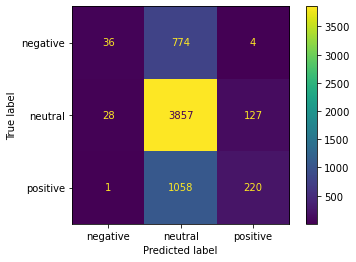

In [25]:
# How to plot confusion matrix
ConfusionMatrixDisplay(MNB_metrics['confusion_M'],display_labels=labels).plot()
plt.savefig("MNB confusion")

# Support Vector Machines (One Vs Rest)

In [19]:
from sklearn import svm

# This function implements one vs rest linear support vector machines model. 
def SVM(C, validation=False):
    
    svm_model = svm.SVC(C=C, kernel='linear')
    
    if validation == True:
        pred = svm_model.fit(X_train_sub, Y_train).predict(X_test_sub)
        accuracy = accuracy_score(Y_test, pred)
        avg_f1 = f1_score(Y_test, pred ,average = 'weighted')
        return accuracy, avg_f1, pred
        
    else:
        pred = svm_model.fit(X_train_final, Y_train_final).predict(X_test_final)
        df = pd.DataFrame(data={"id": tweet_id, "sentiment": pred})
        df.to_csv('One-vs-rest-SVM.csv', index=False)
        return pred

In [27]:
# choices of "k_ratio"
ratio = [0.4,0.5,0.6,0.7]
# choice of "C"
C_lst = [0.5,0.7,1,5,10]

After a series of testing, we found that the combination of "TFIDF" and "k-best-chi" has the greatest performance for both accuracy and weighted averaging f1_score. 

In [ ]:
# Using "TFIDF" and "k-best-chi" and to test different k_ratio and c to find best parameters.

max_f1score = 0
f1_k_ratio = 0
f1_c_value = 0
max_accuracy = 0
acc_k_ratio = 0
acc_c_value = 0

X_train_vec, X_test_vec = vectorizer(X_train, X_test, method="TFIDF", ngram=(1,1))
for k in ratio:
    for c in C_lst:
        X_train_sub, X_test_sub = feature_selection(X_train_vec, Y_train, X_test_vec, method="k-best-chi", kratio=k)
        accuracy, avg_f1, pred = SVM(C = c, validation=True)
        if avg_f1 > max_f1score:
            max_f1score = avg_f1
            f1_k_ratio = k
            f1_c_value = c
        if accuracy > max_accuracy:
            max_accuracy = accuracy
            acc_k_ratio = k
            acc_c_value = c

print("TFIDF")
print("The model with  the highest accuracy is :", max_accuracy, "with ratio of", acc_k_ratio, "and c of", acc_c_value)
print("The model with  the highest weighted avg f1_score is :", max_f1score, "with ratio of", f1_k_ratio, "and c of", f1_c_value)
print("\n")



Since the running time of the above cell is ridiculously long, its result has been saved into this markdown cell.<br> 

*TFIDF<br>
The model with  the highest accuracy is : 0.6835380835380835 with ratio of 0.5 and c of 0.5<br>
The model with  the highest weighted avg f1_score is : 0.6670920932094809 with ratio of 0.6 and c of 1*

It is decided to use C=1 which has the highest f1 score rather than c=0.5(highest accuracy).

In [29]:
# The final SVM model: method="TFIDF", ngram=(1,1), method="k-best-chi", kratio=0.6, C=1
import time

t0 = time.time()
X_train_vec, X_test_vec = vectorizer(X_train_clean, X_test_clean, method="TFIDF", ngram=(1,1))
X_train_final, X_test_final = feature_selection(X_train_vec, Y_train_final, X_test_vec, method="k-best-chi", kratio=0.5)
pred = SVM(C = 1, validation=False)
t1 = time.time() - t0
print("Predict for whole testing set:")
print(Counter(pred))
print("The time: ", t1)

# predict for validation set
X_train_vec, X_test_vec = vectorizer(X_train, X_test, method="TFIDF", ngram=(1,1))
X_train_sub, X_test_sub = feature_selection(X_train_vec, Y_train, X_test_vec, method="k-best-chi", kratio=0.6)
acc, f1, validation_pred = SVM(C = 1, validation=True)
print("\n")
print("Predict for validation set:")
print("The validation accuracy: ", acc)
print("The validation weighted-averaging f1 score: ", f1)

Predict for whole testing set:
Counter({'neutral': 4384, 'positive': 1052, 'negative': 663})
The time:  67.40354871749878


Predict for validation set:
The validation accuracy:  0.6764946764946765
The validation weighted-averaging f1 score:  0.6670920932094809


The final SVM model uses "TFIDF" vectorisation with ngram=(1,1), and "k-best-chi" as feature selection method with k_ratio = 0.6.<br/>
The model has a validation accuracy of 0.6764946764946765 and a weighted averaging f1 score of 0.6670920932094809.<br/> The testing accuracy(40%) on Kaggle was 0.54940. 

### Evaluation

In [30]:
# accuracy, weighted precision, weighted recall, weighted f1, confusion_matrix，error_rate =1-accuracy, time

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from matplotlib import cm
labels=['negative','neutral','positive']

# save all the information for SVM model, which will be use for graph
SVM_metrics={}
SVM_metrics['accuracy'] = accuracy_score(Y_test, validation_pred)
SVM_metrics['weighted_precision'] = precision_score(Y_test, validation_pred, average="weighted")
SVM_metrics['weighted_recall'] = recall_score(Y_test, validation_pred, average="weighted")
SVM_metrics['weighted_f1'] = f1_score(Y_test, validation_pred, average="weighted")
SVM_metrics['confusion_M'] = confusion_matrix(Y_test, validation_pred, labels=labels)
SVM_metrics['time'] = t1
SVM_metrics

{'accuracy': 0.6764946764946765,
 'weighted_precision': 0.662817248710915,
 'weighted_recall': 0.6764946764946765,
 'weighted_f1': 0.6670920932094809,
 'confusion_M': array([[ 297,  494,   23],
        [ 326, 3233,  453],
        [  20,  659,  600]]),
 'time': 67.40354871749878}

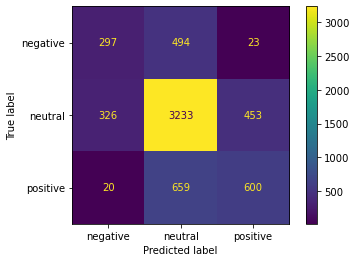

In [31]:
# How to plot confusion matrix
ConfusionMatrixDisplay(SVM_metrics['confusion_M'],display_labels=labels).plot()
plt.savefig("SVM confusion")

# Multi-Class Logistic Regression

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
# This function implements multi-class logistic regression classifer.
def lgr(C,validation=False):
    
    # choices of "solver": "sag" and "saga" are both suitable for large dataset and there is not much difference on
    #                      performance of our model. so we uses "sag"
    # since we have a multi-class problem, we use "multinomial" as multi-class.
    lgr = LogisticRegression(solver="sag", C=C, max_iter=1000, penalty='l2', multi_class='multinomial')
    
    # if we are just validate the accuracy using a subset of trainning set
    if validation == True:
        # random hold-out validation
        pred = lgr.fit(X_train_sub, Y_train).predict(X_test_sub)
        accuracy = accuracy_score(Y_test, pred)
        avg_f1 = f1_score(Y_test, pred, average = "weighted")
        return accuracy, avg_f1, pred
    
    # training using the whole trainning set and predict for the testing set with unknown label
    else:
        pred = lgr.fit(X_train_final, Y_train_final).predict(X_test_final)
        # save test prediction as a csv file
        df = pd.DataFrame(data={"id": tweet_id, "sentiment": pred})
        df.to_csv('Multiclass Logistic Regression.csv', index=False)
        return pred


In [33]:
# choices of parameters
ratio = [0.4,0.5,0.6,0.7]
C_lst = [0.5,1, 5,10]
method = ['BoW','TFIDF']

In [34]:
# using k-best-F to test parameters
for mtype in method:
    
    max_f1score = 0
    f1_k_ratio = 0
    f1_c = 0

    max_acc = 0
    acc_k_ratio = 0
    acc_c = 0
    
    X_train_vec, X_test_vec = vectorizer(X_train, X_test, method=mtype, ngram=(1,1))
    for k in ratio:
        X_train_sub, X_test_sub = feature_selection(X_train_vec, Y_train, X_test_vec, method="k-best-F", kratio=k)
        for c in C_lst:
            acc, f1, pred = lgr(c, validation=True)

            if f1 > max_f1score:
                max_f1score = f1
                f1_k_ratio = k
                f1_c = c
            
            if acc > max_acc:
                max_acc = acc
                acc_k_ratio = k
                acc_c = c
            
    print(mtype)
    print("The model with  the highest accuracy is :", max_acc, "with ratio of ", acc_k_ratio, "and c of", acc_c)
    print("The model with  the highest weighted avg f1_score is :", max_f1score, "with ratio of ", f1_k_ratio, "and c of", f1_c) 
    print("\n")


BoW
The model with  the highest accuracy is : 0.6614250614250614 with ratio of  0.4 and c of 0.5
The model with  the highest weighted avg f1_score is : 0.6549700495726918 with ratio of  0.4 and c of 0.5


TFIDF
The model with  the highest accuracy is : 0.6774774774774774 with ratio of  0.4 and c of 0.5
The model with  the highest weighted avg f1_score is : 0.6621258355541977 with ratio of  0.6 and c of 1




In [33]:
# using k-best-chi to test for different parameters to find the bests
for mtype in method:
    max_f1score = 0
    f1_k_ratio = 0
    f1_c = 0
    
    max_acc = 0
    acc_k_ratio = 0
    acc_c = 0
    
    X_train_vec, X_test_vec = vectorizer(X_train, X_test, method=mtype, ngram=(1,1))
    for k in ratio:
        X_train_sub, X_test_sub = feature_selection(X_train_vec, Y_train, X_test_vec, method="k-best-chi", kratio=k)
        for c in C_lst:
            acc, f1, pred = lgr(c, validation=True)

            if f1 > max_f1score:
                max_f1score = f1
                f1_k_ratio = k
                f1_c = c
            
            if acc > max_acc:
                max_acc = acc
                acc_k_ratio = k
                acc_c = c
            
    print(mtype)
    print("The model with  the highest accuracy is :", max_acc, "with ratio of ", acc_k_ratio, "and c of", acc_c)
    print("The model with  the highest weighted avg f1_score is :", max_f1score, "with ratio of ", f1_k_ratio, "and c of", f1_c) 
    print("\n")



BoW
The model with  the highest accuracy is : 0.6592956592956593 with ratio of  0.4 and c of 0.5
The model with  the highest weighted avg f1_score is : 0.6545554859174986 with ratio of  0.6 and c of 0.5


TFIDF
The model with  the highest accuracy is : 0.6778050778050778 with ratio of  0.5 and c of 0.5
The model with  the highest weighted avg f1_score is : 0.6621428006281156 with ratio of  0.6 and c of 1




It is observed that TFIDF vectorisation has higher performance than BoW; k-best-chi has a slightly better performance than k-best-F. 

In [35]:
# Final model for Logistic Regression: TFIDF, ngram=(1,1), k_ratio = 0.6, C=1

t0 = time.time()
X_train_vec, X_test_vec = vectorizer(X_train_clean, X_test_clean, method="TFIDF", ngram=(1,1))

X_train_final, X_test_final = feature_selection(X_train_vec, Y_train_final, X_test_vec, method="k-best-chi", kratio=0.6)
pred = lgr(C=1, validation = False)
t1 = time.time() - t0
print("Predict for whole testing set:")
print(Counter(pred))
print("The time: ", t1)

# predict for validation set
X_train_vec, X_test_vec = vectorizer(X_train, X_test, method="TFIDF", ngram=(1,1))
X_train_sub, X_test_sub = feature_selection(X_train_vec, Y_train, X_test_vec, method="k-best-chi", kratio=0.6)
acc, f1, validation_pred = lgr(C=1, validation = True)
print("\n")
print("Predict for validation set:")
print("The validation accuracy: ", acc)
print("The validation weighted-averaging f1 score: ", f1)

Predict for whole testing set:
Counter({'neutral': 4267, 'positive': 1142, 'negative': 690})
The time:  4.6390700340271


Predict for validation set:
The validation accuracy:  0.6727272727272727
The validation weighted-averaging f1 score:  0.6621428006281156


The final logistic regression model uses "TFIDF" vectorisation with ngram=(1,1), and "k-best-chi" as feature selection method with k_ratio = 0.6, soft margin C=1.<br/>
The model has a validation accuracy of 0.6727272727272727 and a weighted averaging f1 score of 0.6621428006281156.<br/> The testing accuracy(40%) on Kaggle was 0.55760. 

In [36]:
labels=['negative','neutral','positive']

# save all the information for LGR model, which will be use for graph
LGR_metrics={}
LGR_metrics['accuracy'] = accuracy_score(Y_test, validation_pred)
LGR_metrics['weighted_precision'] = precision_score(Y_test, validation_pred, average="weighted")
LGR_metrics['weighted_recall'] = recall_score(Y_test, validation_pred, average="weighted")
LGR_metrics['weighted_f1'] = f1_score(Y_test, validation_pred, average="weighted")
LGR_metrics['confusion_M'] = confusion_matrix(Y_test, validation_pred, labels=labels)
LGR_metrics['time'] = t1
LGR_metrics

{'accuracy': 0.6727272727272727,
 'weighted_precision': 0.6574767056379339,
 'weighted_recall': 0.6727272727272727,
 'weighted_f1': 0.6621428006281156,
 'confusion_M': array([[ 274,  510,   30],
        [ 303, 3233,  476],
        [  17,  662,  600]]),
 'time': 4.6390700340271}

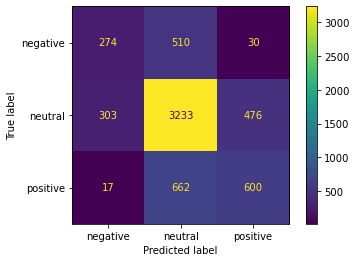

In [37]:
# Visualise confusion matrix
ConfusionMatrixDisplay(LGR_metrics['confusion_M'],display_labels=labels).plot()
# save fig if nessesary
plt.savefig("LGR confusion")

# Random Forest

In [21]:
# This cell implements the random forest model. 
from sklearn.ensemble import RandomForestClassifier
# using 100 decision trees, spliting node by 'entropy'(information gain),"gini"-gini impurity, 
forest = RandomForestClassifier(n_estimators=200, criterion="entropy", max_depth=150, min_samples_split=10,
                                min_samples_leaf=1, max_features="sqrt")
# predict for validation set
X_train_vec, X_test_vec = vectorizer(X_train, X_test, method="BoW", ngram=(1,1))
X_train_sub, X_test_sub = feature_selection(X_train_vec, Y_train, X_test_vec, method="k-best-chi", kratio=0.6)
validation_pred = forest.fit(X_train_sub, Y_train).predict(X_test_sub)
accuracy = accuracy_score(Y_test, validation_pred)
f1 = f1_score(Y_test, validation_pred, average = "weighted")
(accuracy,f1) 

(0.6825552825552825, 0.6422418510317794)

A trial comparision of results using different vectorisation methods:<br>
tfidf: (0.6819000819000819, 0.6461283343861257)<br>
bow: (0.6805896805896806, 0.6396399114230008)<br>
It is noticed that TFIDF random forest has a better performance than BoW random forest. So "TFIDF" is used. <br>
NOTE: The above results may vary every time we run the random forest model since this classifier selects features at random, which means that the model would not be the same everytime. However, we have tested for several trials and TFIDF always perform slightly better than BoW.

In [39]:
# predict for the whole test set 
# Note that the output of this prediction will not be the same if you run the code again, due to randomness in random
# forest
t0=time.time()
X_train_vec, X_test_vec = vectorizer(X_train_clean, X_test_clean, method="TFIDF", ngram=(1,1))
X_train_final, X_test_final = feature_selection(X_train_vec, Y_train_final, X_test_vec, method="k-best-chi", kratio=0.6)
pred = forest.fit(X_train_final, Y_train_final).predict(X_test_final)
df = pd.DataFrame(data={"id": tweet_id, "sentiment": pred})
df.to_csv('Random_forest.csv', index=False)
t1 = time.time() - t0

print("Predict for whole testing set:")
print(Counter(pred))
print("The time: ", t1)


Predict for whole testing set:
Counter({'neutral': 5046, 'positive': 799, 'negative': 254})
The time:  30.365751028060913


The final random forest model uses "TFIDF" vectorisation with ngram=(1,1), and "k-best-chi" as feature selection method with k_ratio = 0.6, n_estimators=200, criterion="entropy", max_depth=150, min_samples_split=10,
min_samples_leaf=1, max_features="sqrt".<br/>
The model has a validation accuracy of 0.6837018837018837 and a weighted averaging f1 score of 0.6441274410953975. (Again, this validation result may vary if running the random forest classifier again due to randomness)<br>
The testing accuracy(40%) on Kaggle was 0.47273. 

In [40]:
labels=['negative','neutral','positive']


# save all the information for RF model, which will be use for graph
RF_metrics={}
RF_metrics['accuracy'] = accuracy_score(Y_test, validation_pred)
RF_metrics['weighted_precision'] = precision_score(Y_test, validation_pred, average="weighted")
RF_metrics['weighted_recall'] = recall_score(Y_test, validation_pred, average="weighted")
RF_metrics['weighted_f1'] = f1_score(Y_test, validation_pred, average="weighted")
RF_metrics['confusion_M'] = confusion_matrix(Y_test, validation_pred, labels = labels)
RF_metrics['time'] = t1
RF_metrics

{'accuracy': 0.6810810810810811,
 'weighted_precision': 0.6520998230106546,
 'weighted_recall': 0.6810810810810811,
 'weighted_f1': 0.6419995926394101,
 'confusion_M': array([[ 127,  666,   21],
        [ 117, 3574,  321],
        [   6,  816,  457]]),
 'time': 30.365751028060913}

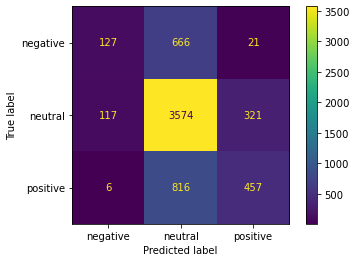

In [41]:
# Visualise confusion matrix
ConfusionMatrixDisplay(RF_metrics['confusion_M'],display_labels=labels).plot()
# save fig if nessesary
plt.savefig("RF confusion")

# Ensemble model – stacking

In [24]:
import numpy as np
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB 
from sklearn import svm
from sklearn.metrics import accuracy_score

# use the previous 4 models as base model in stacking, and final classifer as logistic Regression using the outcomes
# of the 4 base models
classifiers = [("SVM",svm.SVC(C=1, kernel='linear')),
               ("MNB",MultinomialNB()),
               ("RandomForest",RandomForestClassifier(n_estimators=200, criterion="entropy", max_depth=150, min_samples_split=10,
                                min_samples_leaf=1, max_features="sqrt")),
               ("LogisticReg", LogisticRegression(solver="sag", C=1, max_iter=200, penalty='l2', multi_class='multinomial'))]

stacker_lr = StackingClassifier(estimators=classifiers, 
                                final_estimator = LogisticRegression(solver="sag", C=1, max_iter=200, penalty='l2', multi_class='multinomial'))


In [43]:
# accuracy based on validation set
X_train_vec, X_test_vec = vectorizer(X_train, X_test, method="TFIDF", ngram=(1,1))
X_train_sub, X_test_sub = feature_selection(X_train_vec, Y_train, X_test_vec, method="k-best-chi", kratio=0.6)
validation_pred = stacker_lr.fit(X_train_sub, Y_train).predict(X_test_sub)
print("Stack validation Accuracy:", accuracy_score(Y_test, validation_pred))
print("Stack validation weighted-averaging:", f1_score(Y_test, validation_pred, average="weighted"))

Stack validation Accuracy: 0.6592956592956593
Stack validation weighted-averaging: 0.6596251992410703


In [44]:
# Predictions of the test data
# Note that the output of this prediction will not be the same if you run the code again, due to randomness in random
# forest

t0=time.time()
X_train_vec, X_test_vec = vectorizer(X_train_clean, X_test_clean, method="TFIDF", ngram=(1,1))
X_train_final, X_test_final = feature_selection(X_train_vec, Y_train_final, X_test_vec, method="k-best-chi", kratio=0.6)

stack_model = stacker_lr.fit(X_train_final, Y_train_final).predict(X_test_final)
df = pd.DataFrame(data={"id": tweet_id, "sentiment": stack_model})
df.to_csv('Stacking.csv', index=False)
t1 = time.time() - t0

print("Predict for whole testing set:")
print(Counter(stack_model))
print("The time: ", t1)

Predict for whole testing set:
Counter({'neutral': 3895, 'positive': 1303, 'negative': 901})
The time:  639.4721891880035


The final stacking model uses "TFIDF" vectorisation with ngram=(1,1), and "k-best-chi" as feature selection method with k_ratio = 0.6, all of models as base-estimators and logistic regression estimator as the meta classifier.<br/>
The model has a validation accuracy of 0.6604422604422604 and a weighted averaging f1 score of 0.6608697664082144.<br/> The testing accuracy(40%) on Kaggle was 0.58548. 

In [45]:
Stacking_metrics={}


# save all the information for Stacking model, which will be use for graph
Stacking_metrics['accuracy'] = accuracy_score(Y_test, validation_pred)
Stacking_metrics['weighted_precision'] = precision_score(Y_test, validation_pred, average="weighted")
Stacking_metrics['weighted_recall'] = recall_score(Y_test, validation_pred, average="weighted")
Stacking_metrics['weighted_f1'] = f1_score(Y_test, validation_pred, average="weighted")
Stacking_metrics['confusion_M'] = confusion_matrix(Y_test, validation_pred, labels=labels)
Stacking_metrics['time'] = t1
Stacking_metrics

{'accuracy': 0.6592956592956593,
 'weighted_precision': 0.6599660786476363,
 'weighted_recall': 0.6592956592956593,
 'weighted_f1': 0.6596251992410703,
 'confusion_M': array([[ 360,  427,   27],
        [ 431, 2990,  591],
        [  26,  578,  675]]),
 'time': 639.4721891880035}

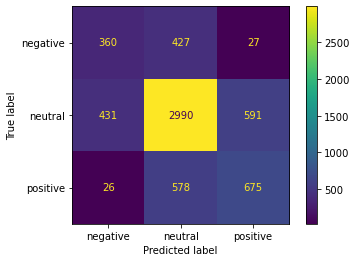

In [50]:
# Visualise confusion matrix
ConfusionMatrixDisplay(Stacking_metrics['confusion_M'],display_labels=labels).plot()
# save fig if nessesary
plt.savefig("Stacking_confusion")

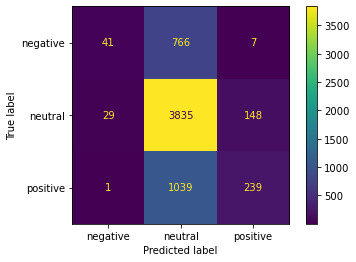

In [49]:
X_train_vec, X_test_vec = vectorizer(X_train, X_test, method="TFIDF", ngram=(1,1))
X_train_sub, X_test_sub = feature_selection(X_train_vec, Y_train, X_test_vec, method="k-best-chi", kratio=0.6)
acc, f1, validation_pred_tfidf = MNB(validation=True)

# Visualise confusion matrix
ConfusionMatrixDisplay(confusion_matrix(Y_test, validation_pred_tfidf, labels=labels),display_labels=labels).plot()
# save fig if nessesary
plt.savefig("MNB TFIDF")

## Adjust dataset in order to let training set have the same class distribution

In [56]:
import random

positive= []
negative = []
neutral = []
# classify the training dataset into three classes
for i in range(len(X_train_clean)):
    if Y_train_final[i] == "positive":
        positive.append(X_train_clean[i])
    elif Y_train_final[i] == "negative":
        negative.append(X_train_clean[i])
    elif Y_train_final[i] == "neutral":
        neutral.append(X_train_clean[i])

# we have learnt that negative sentiment is the least in the dataset, therefore we randomly extract the 
# same number of negative sentiment from three classified dataset,
r_positive = random.choices(positive, k=len(negative))
r_neutral = random.choices(neutral, k=len(negative))
r_negative = negative
x_adjust_train = r_positive+r_neutral+r_negative

sentiment = ['positive', 'neutral', 'negative']
y_adjust_train = [i for i in sentiment for n in range(len(negative))]


In [57]:
# use the adjusted training data to run stacking model

# predict for validation set
# we have a much smaller dataset now, but we'll still split the balanced dataset with test size = 0.28 of training
X_train, X_test, Y_train, Y_test = train_test_split(x_adjust_train, y_adjust_train, test_size=0.28, shuffle=True, random_state=42)
X_train_vec, X_test_vec = vectorizer(X_train, X_test, method="TFIDF", ngram=(1,1))
X_train_sub, X_test_sub = feature_selection(X_train_vec, Y_train, X_test_vec, method="k-best-chi", kratio=0.8)
validation_pred = stacker_lr.fit(X_train_sub, Y_train).predict(X_test_sub)
print("Stack validation Accuracy:", accuracy_score(Y_test, validation_pred))
print("Stack validation weighted-averaging f1:", f1_score(Y_test, validation_pred, average="weighted"))
# Note that the output of this prediction will not be the same if you run the code again, due to randomness in random
# forest and process of generating balanced data

Stack validation Accuracy: 0.6613264979173342
Stack validation weighted-averaging f1: 0.658767171083002


Since the feature size has been reduced significantly if the balanced training set is used, we thought it might be necessary to increase the number of features (k_ratio). So we ran some trials with exact same classfifer(stacking) and parameters but different values of k_ratio. The results have been recorded below. <br>

kratio=0.6:<br>
Stack validation Accuracy: 0.6744633130406921<br>
Stack validation weighted-averaging f1: 0.6710532198546785<br>

kratio=0.7:<br>
Stack validation Accuracy: 0.6776674142902915<br>
Stack validation weighted-averaging f1: 0.6742301866637038<br>

kratio=0.8:<br>
Stack validation Accuracy: 0.6799102851650112<br>
Stack validation weighted-averaging f1: 0.6762185768173528<br>

It turns out that the new stacking model performed the best when k_ratio = 0.8.  <br>
Therefore, it is decided that our final stacking model with balanced training set uses TFIDF with unigrams, selectKbest with chi-square feature selection with 0.8 k_ratio. 

In [58]:
# Predictions of the test data
# Note that the output of this prediction will not be the same if you run the code again, due to randomness in random
# forest and process of generating balanced data

import time
t0 = time.time()
X_train_vec, X_test_vec = vectorizer(x_adjust_train, X_test_clean, method="TFIDF", ngram=(1,1))
X_train_final, X_test_final = feature_selection(X_train_vec, y_adjust_train, X_test_vec, method="k-best-chi", kratio=0.8)

stack_model = stacker_lr.fit(X_train_final, y_adjust_train).predict(X_test_final)
df = pd.DataFrame(data={"id": tweet_id, "sentiment": stack_model})
df.to_csv('Stacking.csv', index=False)
t1 = time.time() - t0

print("Predict for whole testing set:")
print(Counter(stack_model))
print("The time: ", t1)

Predict for whole testing set:
Counter({'negative': 2246, 'positive': 1934, 'neutral': 1919})
The time:  221.0543360710144


In [59]:
Stack_balance_metrics={}
Stack_balance_metrics['accuracy'] = accuracy_score(Y_test, validation_pred)
Stack_balance_metrics['weighted_precision'] = precision_score(Y_test, validation_pred, average="weighted")
Stack_balance_metrics['weighted_recall'] = recall_score(Y_test, validation_pred, average="weighted")
Stack_balance_metrics['weighted_f1'] = f1_score(Y_test, validation_pred, average="weighted")
Stack_balance_metrics['confusion_M'] = confusion_matrix(Y_test, validation_pred)
Stack_balance_metrics['time'] = t1
Stack_balance_metrics

{'accuracy': 0.6613264979173342,
 'weighted_precision': 0.657679968307072,
 'weighted_recall': 0.6613264979173342,
 'weighted_f1': 0.658767171083002,
 'confusion_M': array([[740, 189,  95],
        [272, 548, 224],
        [ 70, 207, 776]]),
 'time': 221.0543360710144}

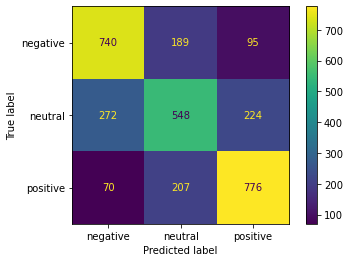

In [60]:
# Visualise confusion matrix
ConfusionMatrixDisplay(Stack_balance_metrics['confusion_M'],display_labels=labels).plot()
# save fig if nessesary
plt.savefig("Stack balance metrics")

### Graphs for discussion

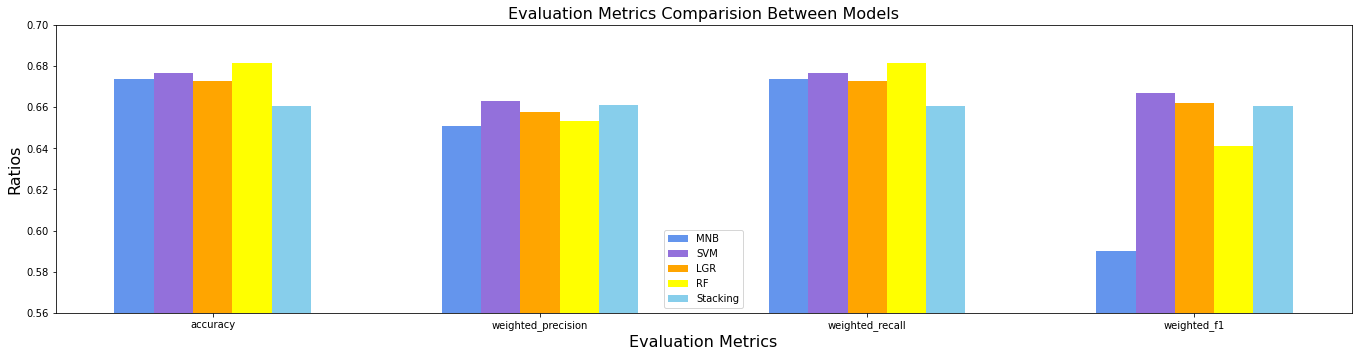

In [61]:
# accuracy, weighted precision, weighted recall, weighted f1
n_groups = 4
MNB = (MNB_metrics["accuracy"], MNB_metrics["weighted_precision"], MNB_metrics["weighted_recall"], 
      MNB_metrics["weighted_f1"])
SVM = (SVM_metrics["accuracy"], SVM_metrics["weighted_precision"], SVM_metrics["weighted_recall"], 
      SVM_metrics["weighted_f1"])
LGR = (LGR_metrics["accuracy"], LGR_metrics["weighted_precision"], LGR_metrics["weighted_recall"], 
      LGR_metrics["weighted_f1"])
RF = (RF_metrics["accuracy"], RF_metrics["weighted_precision"], RF_metrics["weighted_recall"], 
      RF_metrics["weighted_f1"])
Stacking = (Stacking_metrics["accuracy"], Stacking_metrics["weighted_precision"], Stacking_metrics["weighted_recall"], 
      Stacking_metrics["weighted_f1"])


# create plot
fig = plt.figure()
ax = fig.add_axes([0,0,3,1])
index = np.arange(n_groups)
bar_width = 0.12

rects1 = ax.bar(index, MNB, bar_width,
color='cornflowerblue',
label='MNB')

rects2 = ax.bar(index + bar_width, SVM, bar_width,
color='mediumpurple',
label='SVM')

rects3 = ax.bar(index + 2*bar_width, LGR, bar_width,
color='orange',
label='LGR')

rects4 = ax.bar(index + 3*bar_width, RF, bar_width,
color='yellow',
label='RF')

rects5 = ax.bar(index + 4*bar_width, Stacking, bar_width,
color='skyblue',
label='Stacking')



plt.xlabel('Evaluation Metrics', fontsize=16)
plt.ylabel('Ratios', fontsize=16)
plt.title('Evaluation Metrics Comparision Between Models', fontsize=16)
plt.xticks(index + 2*bar_width, ('accuracy', 'weighted_precision', 'weighted_recall', 'weighted_f1'))
plt.ylim(0.56, 0.70) 
plt.legend()
plt.savefig("Evaluation Metrics Comparision Between Models.png", bbox_inches = 'tight')


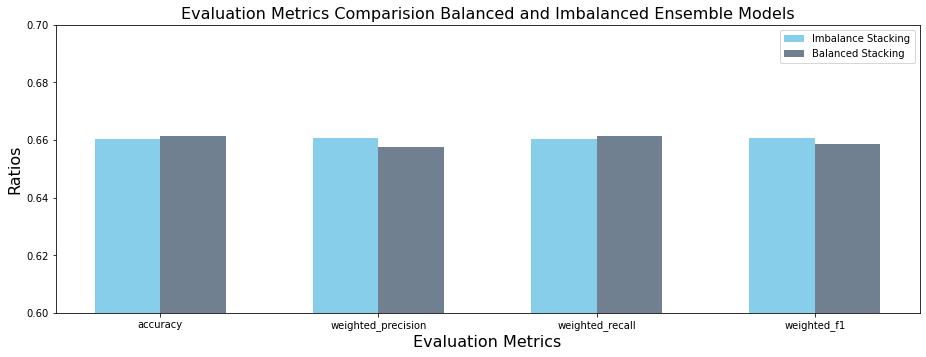

In [62]:
n_groups = 4

Stacking = (Stacking_metrics["accuracy"], Stacking_metrics["weighted_precision"], Stacking_metrics["weighted_recall"], 
      Stacking_metrics["weighted_f1"])
Stack_balance = (Stack_balance_metrics["accuracy"], Stack_balance_metrics["weighted_precision"], Stack_balance_metrics["weighted_recall"], 
      Stack_balance_metrics["weighted_f1"])


# create plot
fig = plt.figure()
ax = fig.add_axes([0,0,2,1])
index = np.arange(n_groups)
bar_width = 0.3

rects_im = ax.bar(index + bar_width, Stacking, bar_width,
color='skyblue',
label='Imbalance Stacking')

rects_b = ax.bar(index + 2*bar_width, Stack_balance, bar_width,
color='slategrey',
label='Balanced Stacking')


plt.xlabel('Evaluation Metrics', fontsize=16)
plt.ylabel('Ratios', fontsize=16)
plt.title('Evaluation Metrics Comparision Balanced and Imbalanced Ensemble Models', fontsize=16)
plt.xticks(index + 1.5*bar_width, ('accuracy', 'weighted_precision', 'weighted_recall', 'weighted_f1'))
plt.ylim(0.6, 0.70) 
plt.legend()
plt.savefig("Evaluation Metrics Stacking.png", bbox_inches = 'tight')



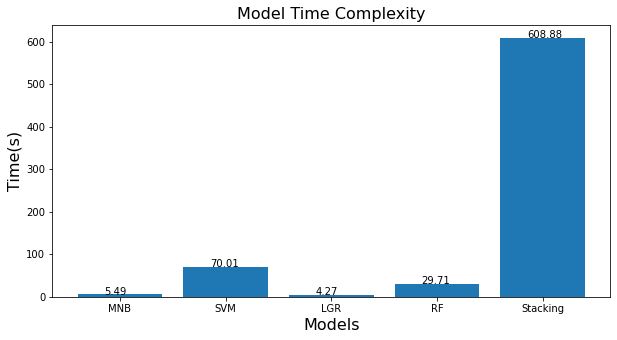

In [63]:
# Time Complexity between Models
n_groups = 5

all_time = (MNB_metrics["time"], SVM_metrics["time"],LGR_metrics['time'] , RF_metrics['time'], Stacking_metrics['time'])

models = ("MNB", "SVM", "LGR", "RF", "Stacking")

indx = np.arange(n_groups)
fig, ax = plt.subplots(figsize = (10,5))
ax.bar(indx,all_time,width=0.8)

for index,data in enumerate(all_time):
    data = round(data,2)
    plt.text(x=index-0.15, y=data, s=f"{data}", fontdict=dict(fontsize=10))
plt.xlabel('Models', fontsize=16)
plt.ylabel('Time(s)', fontsize=16)
plt.title('Model Time Complexity', fontsize=16)
plt.xticks(indx, ('MNB', 'SVM', 'LGR', 'RF', 'Stacking'))

plt.savefig("Model Time Complexity")
plt.show()
